# SMAI Assignment - 2

## Question - `3` : Multinomial Naïve Bayes

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `16.02.2023` |
| Due Date | `24.02.2023` |

This question will have you working and experimenting with the Multinomial Naïve Bayes classifier. Initially, you will transform the given data in csv file to count matrix, then calculate the priors. Use those priors to compute likelyhoods according to Multinomial Naive Bayes and then classify the test data. Please note that use of `sklearn` implementations is only for the final question of the assignment, for other doubts regarding libraries you can reach out to the TAs.

The dataset is about `Spam SMS`. There is 1 attribute that is the `message`, and the class label which could be `spam` or `ham`. The data is present in `spam.csv`. It contains about 5-6000 samples.
For your convinience the data is already pre-processed and loaded, but I suggest you to just take a look at the code for your own knowledge, and parts vectorization is left up to you which could be easily done with the help of the given example code.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

## Reading text-based data using pandas

In [ ]:
# read file into pandas using a relative path

df = pd.read_csv("./spam.csv", encoding='latin-1')
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label', 'message']

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Pre-processing

- Our main issue with our data is that it is all in text format (strings). The classification algorithms that we usally use need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the bag-of-words approach, where each unique word in a text will be represented by one number.

- As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

In [ ]:
import string
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['message'] = df.message.apply(text_process)
df.head()

,label,message
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif oni
2,spam,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,dun say early hor c already say
4,ham,Nah think goes usf lives around though


In [ ]:
df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,message
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif oni
2,1,Free entry wkly comp win FA Cup final tkts 21s...
3,0,dun say early hor c already say
4,0,Nah think goes usf lives around though


## Splitting the data

In [ ]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split

X = df.message
y = df.label

print(f'X: {X.shape}')
print(f'y: {y.shape}')
print()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print()

print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print()

X: (5572,)
y: (5572,)

X_train: (4179,)
y_train: (4179,)

X_test: (1393,)
y_test: (1393,)



## Helper code / Example code for Representing text as Numerical data using Sci-kit learn

📌 From the scikit-learn documentation:
- Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.
- We will use CountVectorizer to "convert text into a matrix of token counts":

In [ ]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'Please call me... PLEASE!']

In [ ]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
simple_train = vect.fit_transform(simple_train)

vect.get_feature_names_out()

array(['cab', 'call', 'me', 'please', 'tonight', 'you'], dtype=object)

In [ ]:
vect.get_feature_names_out()

array(['cab', 'call', 'me', 'please', 'tonight', 'you'], dtype=object)

In [ ]:
# convert sparse matrix to a dense matrix
simple_train.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In this scheme, features and samples are defined as follows:

- Each individual token occurrence frequency (normalized or not) is treated as a feature.
- The vector of all the token frequencies for a given document is considered a multivariate sample.

A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

In [ ]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


### Transform Testing data into a document-term matrix (using existing / training vocabulary)

- You are supposed to use the training vocabolary to make the count matrix for test data

In [ ]:
simple_test = ["please don't call me"]

In [ ]:
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [ ]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


## Multinomial Naive Bayes Implementation

- Your task is to implement Mutlinomial Naive Bayes from scratch, you can use numpy to vectorize your code and matplotlib  to show your analysis.
- Below some information has given from the documentation about Multinomial Naive Bayes, this will give you some idea about using *Smoothing Priors*.
- There is a sub-question for experimenting with $\alpha > 0$, you don't have to implement it separetely, try to incomporate it in same Model Class / Function.

📌 From the scikit-learn documentation:

- Multinomial Naive Bayes implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).

- The distribution $\theta_y = (\theta_{y1}, \theta_{y2}, \dots, \theta_{yn})$ is parametrized by vectors for each class $y$, where $n$ is the number of features (in text classification, the size of the vocabulary) and $\theta_{yi}$ is the probability $P(x_i|y)$ of feature appearing in a sample belonging to class.

- The parameters $\theta_y$ is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:

$$
\hat{\theta}_{yi} = \frac{N_{yi} + \alpha}{N_{y} + \alpha n}
$$

 where $N_{yi} = \sum_{x \in T}{x_i}$ is the number of times feature $i $ appears in a sample of class in the training set $T$, and $N_{y} = \sum^{n}_{i=1}{N_{yi}}$ is the total count of all features for class $y$.

- The smoothing priors $\alpha \gt 0$ accounts for features not present in the learning samples and **prevents zero probabilities** in further computations. Setting $\alpha = 1$ is called Laplace smoothing, while $\alpha \lt 1$ is called Lidstone smoothing.


In [ ]:
"""
Your code here
"""
class m_naive_bayes:
  def __init__(self, alpha):
    self.alpha = alpha

  def fit(self, X, y):
    n, m = X.shape
    self.p_spam = (y == 1).sum()/y.shape[0]
    self.p_ham = 1 - self.p_spam
    self.conditional_probabilities = np.zeros((2, m))
    subset = X[y == 0, :]
    total_count = np.sum(subset)
    self.conditional_probabilities[0, :] = self.formula(subset, total_count, m)  
    subset = X[y == 1, :]
    total_count = np.sum(subset)
    self.conditional_probabilities[1, :] = self.formula(subset, total_count, m)

  def formula(self, X, tc, n):
    sum = np.sum(X, axis=0)
    # print(sum)
    numerator = sum + self.alpha
    # print(numerator)
    denomenator = tc + self.alpha * n
    return numerator/denomenator

  def predict(self, X):
    predictions = []
    conditional_p = np.log(self.conditional_probabilities)  
    for sample in X:
      spam_score = (sample * conditional_p[1]).sum() + np.log(self.p_spam)
      ham_score = (sample * conditional_p[0]).sum() + np.log(self.p_ham)
      predictions.append((spam_score > ham_score)*1)
    return predictions

## Vectorizing Training Sample

- Use the Helper code above to vectorize for training samples
- Don't overthink it, its very easy to do

In [ ]:
"""
Your code here
"""
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
trainX = vect.fit_transform(X_train)

## Calculate Priors and Estimate Model's performance on Training Sample

- Calculate priors based on Training Sample using your NB implementation
- Evaluate your model's performance on Training Data ($\alpha = 0$)

In [ ]:
"""
Your code here
"""
from sklearn.metrics import accuracy_score

model = m_naive_bayes(0)
model.fit(trainX, y_train)
prediction = model.predict(trainX)
accuracy_score(prediction, y_train)

0.9971284996410624

## Vectorizing Test Sample

- Use the Training Sample vocabulary to create word count matrix for test samples
- This is also shown in the Helper code

In [ ]:
"""
Your code here
"""
testX = simple_test_dtm = vect.transform(X_test)

## Estimate Model's performance on Test Sample

- Evaluate your model's performance on Test Sample, using the Training Priors ($\alpha = 0$)

In [ ]:
model = m_naive_bayes(0)
model.fit(trainX, y_train)
prediction = model.predict(testX)
accuracy_score(prediction, y_test)

0.9569274946159368

## Select Smoothing Priors

- Refactor your code to incorporate smoothing priors, select $\alpha = 0$ for the previous estimates / sub-questions
- Compare the performance with different values of $\alpha \gt 0$ as smoothing priors to take care of zero probabilities
- You can display a Plot or Table to show the comparison.

In [ ]:
from sklearn.metrics import accuracy_score
alphas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.55, 0.6, 0.65, 1, 2, 4, 8, 16, 50]
scores = []
for alpha in alphas:
  model = m_naive_bayes(alpha)
  model.fit(trainX, y_train)
  prediction = model.predict(testX)
  scores.append(accuracy_score(prediction, y_test))

highest accuracy is 98.7078248384781% for alpha = 0.6


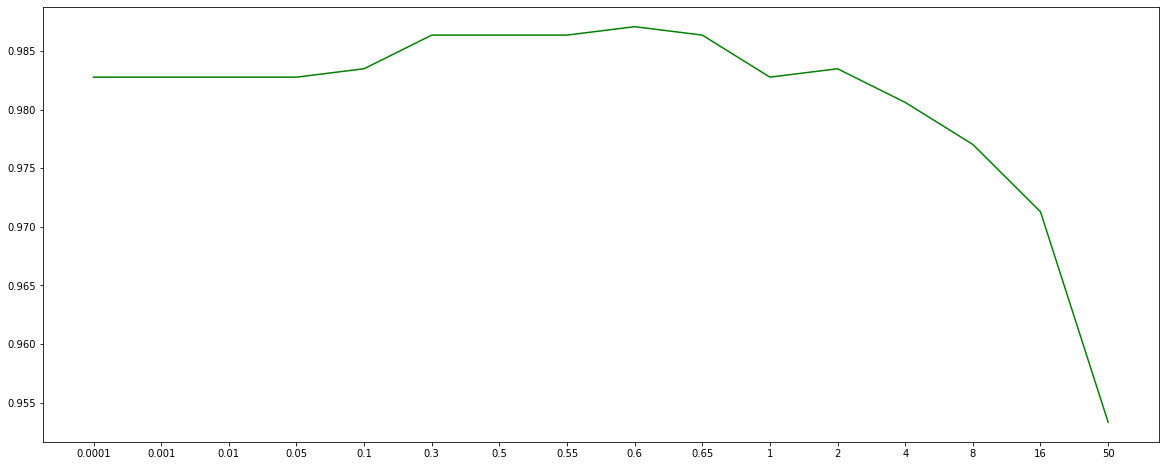

In [ ]:
print(f'highest accuracy is {max(scores)*100}% for alpha = {alphas[np.argmax(scores)]}')
plt.figure(figsize = (20, 8))
alphas_s = [str(val) for val in alphas]
plt.plot(alphas_s, scores, color = "green")
plt.show()

## Comparison with Sci-kit Learn Implementation

- Use sci-kit learn's `sklearn.naive_bayes.MultinomialNB` model to compare your implementation's performance
- (Optional) try other classifiers from `sklearn.naive_bayes` and see if you can make them work`

In [ ]:
"""
Your code here
"""
from sklearn.naive_bayes import MultinomialNB
alphas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.55, 0.6, 0.65, 1, 2, 4, 8, 16, 50]
scoress = []
for alp in alphas:
  model = MultinomialNB(alpha = alp)
  model.fit(trainX, y_train)
  prediction = model.predict(testX)
  scoress.append(accuracy_score(prediction, y_test))

highest accuracy is 98.7078248384781% for alpha = 0.6


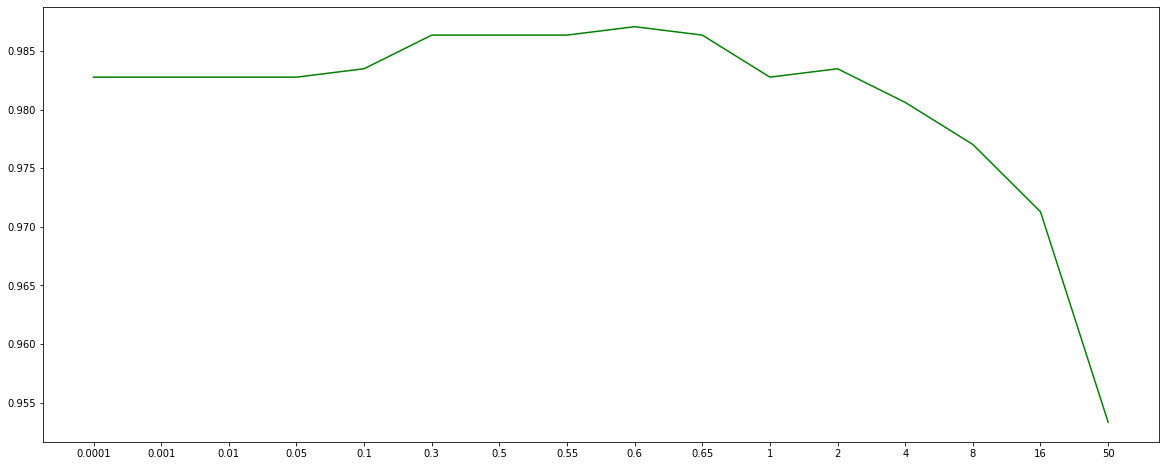

In [ ]:
print(f'highest accuracy is {max(scoress)*100}% for alpha = {alphas[np.argmax(scoress)]}')
plt.figure(figsize = (20, 8))
alphas_s = [str(val) for val in alphas]
plt.plot(alphas_s, scoress, color = "green")
plt.show()

***Surprisingly!!!***

***The Accuracies and the Graph turn out to be exactly same for my implementation and Sklern MultinomialNB***